In [74]:
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random
import jax

from jaxgp.kernels import RBF
from jaxgp.utils import *

import matplotlib.pyplot as plt

In [75]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]

    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [76]:
def k_inv(X_split, X_ref, noise, kernel, params) -> jnp.ndarray:
    # calculates the covariance between the training points and the reference points
    KF = CovMatrixFF(X_ref, X_split[0], kernel, params)
    KD = CovMatrixFD(X_ref, X_split[1], kernel, params)
    
    K_MN = jnp.hstack((KF,KD))
    
    # calculates the covariance between each pair of reference points
    K_ref = CovMatrixFF(X_ref, X_ref, kernel, params)
    diag = jnp.diag_indices(len(K_ref))

    # added small positive diagonal to make the matrix positive definite
    K_ref = K_ref.at[diag].add(1e-4)
    K_ref, _ = jsp.linalg.cho_factor(K_ref)

    # FITC
    # ---------------------------------------------------------------------------
    func = jax.vmap(lambda v: kernel.eval(v, v, params), in_axes=(0))(X_split[0])
    der = jnp.ravel(jax.vmap(lambda v: jnp.diag(kernel.jac(v, v, params)), in_axes=(0))(X_split[1]))
    full_diag = jnp.hstack((func, der))
    sparse_diag = jax.vmap(lambda A, x: x.T@jsp.linalg.cho_solve((A, False),x), in_axes=(None, 0))(K_ref, K_MN.T)    
    fitc_diag = (full_diag - sparse_diag) + noise**2


    K_inv = K_ref + K_MN@jnp.diag(1 / fitc_diag)@K_MN.T
    diag = jnp.diag_indices(len(K_inv))
    # K_inv = K_inv.at[diag].add(val)

    # min_eigen = jnp.min(jnp.linalg.eigvals(K_inv))
    # is_sym = jnp.allclose(K_inv, K_inv.T)

    # return min_eigen, is_sym
    rel_err = jnp.max(jnp.abs(K_inv-K_inv.T)) / jnp.max(K_inv)
    max_elem = jnp.max(K_inv)

    return rel_err, max_elem

In [77]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 1000

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

num_ref_points = (num_d_vals + num_f_vals) // 10
key, subkey = random.split(key)
X_ref_rand = random.permutation(subkey, jnp.vstack((x_der,x_func)))[:num_ref_points]
# this grid has fewer points. It has N points, where N is the largest perfect square smaller than num_ref_points
X_ref_even = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))),jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))))).reshape(2,-1).T

X_split = [x_func,x_der]
Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

kernel = RBF()
# an RBF kernel has per default 2 parameters

In [84]:
param_bounds = jnp.array([0.2,20.0])
num_params = 30
grid = jnp.linspace(*param_bounds, num_params)
params = jnp.array(jnp.meshgrid(grid,grid)).reshape(2,-1).T

In [85]:
X_ref = X_ref_even

In [86]:
func = lambda x: jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)

In [87]:
# min_eigen = []
# is_sym = []
rel_err = []
max_elem = []

for param in params:
    # m, i = func(param)
    # min_eigen.append(m)
    # is_sym.append(i)
    r, m = func(param)
    rel_err.append(r)
    max_elem.append(m)

# min_eigen = jnp.array(min_eigen).reshape(num_params, num_params)
# is_sym = jnp.array(is_sym).reshape(num_params, num_params)
rel_err = jnp.array(rel_err).reshape(num_params, num_params)
max_elem = jnp.array(max_elem).reshape(num_params, num_params)

Text(0, 0.5, 'length-scale')

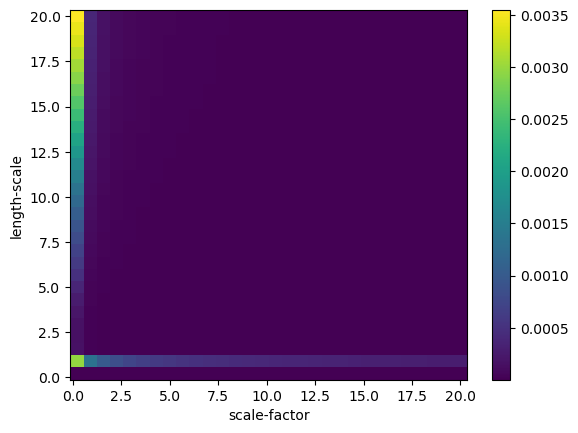

In [88]:
plt.pcolormesh(grid, grid, rel_err)
plt.colorbar()
plt.xlabel("scale-factor")
plt.ylabel("length-scale")

Text(0, 0.5, 'length-scale')

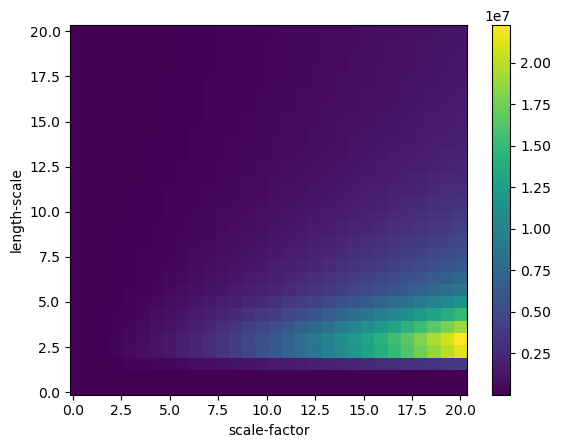

In [89]:
plt.pcolormesh(grid, grid, max_elem)
plt.colorbar()
plt.xlabel("scale-factor")
plt.ylabel("length-scale")